# Anomaly Detection with Gaussian Mixture Model - Part 4

We will now try out the other Gaussian models and see which is best.
See here for the description of the models:

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.mixture

and here:

http://scikit-learn.org/stable/modules/mixture.html#mixture


In [29]:
import numpy as np
import sklearn as sk
from sklearn import mixture
import pandas as pd
%pylab inline

pd.set_option('display.mpl_style', 'default')
plt.rcParams["figure.figsize"] = (18,4)


Populating the interactive namespace from numpy and matplotlib


In [30]:
def get_train_data(data_size):
    m=data_size/5
    df1 = pd.DataFrame(random.randn(m,2)-20, columns=['x','y'])
    df2 = pd.DataFrame(random.randn(m*2,2)-10, columns=['x','y'])
    df2.y=-df2.x*3-10 + random.randn(m*2)*2    
    df3 = pd.DataFrame(random.randn(m,2), columns=['x','y'])
    df3.y=df3.x*2-10 + random.randn(m)
    return df1.append(df2).append(df3)
    
def train_anomaly_models(df, n_components=3, cov_type='full'):
    models=[]
    models.append( mixture.GMM(n_components, covariance_type=cov_type) )
    models.append( mixture.DPGMM(n_components, covariance_type=cov_type) )
    models.append( mixture.VBGMM(n_components, covariance_type=cov_type) )
    for model in models:
        model.fit(df[['x','y']])
    return models

def choose_best_model(df, dftest):    
    (min_bic,min_model) = (1e100, 'unknown')
    for n_components in np.arange(5)+1:
        for cov_type in ['spherical', 'tied', 'diag', 'full']:
            models = train_anomaly_models(df, n_components, cov_type)
            for model in models:
                bic = model.bic(dftest)
                #print n_components, cov_type, bic
                if ((bic>0) & (bic<min_bic)):
                    (min_bic,min_model) = (bic, model)
    return min_bic, min_model

df = get_train_data(1000)
dftest = get_train_data(1000)
bic, model = choose_best_model(df, dftest)
print 'model = {}\nbic = {}'.format(model, bic)


model = DPGMM(alpha=1.0, covariance_type='full', init_params='wmc', min_covar=None,
   n_components=3, n_iter=10, params='wmc', random_state=None, thresh=None,
   tol=0.001, verbose=0)
bic = 107.704193534


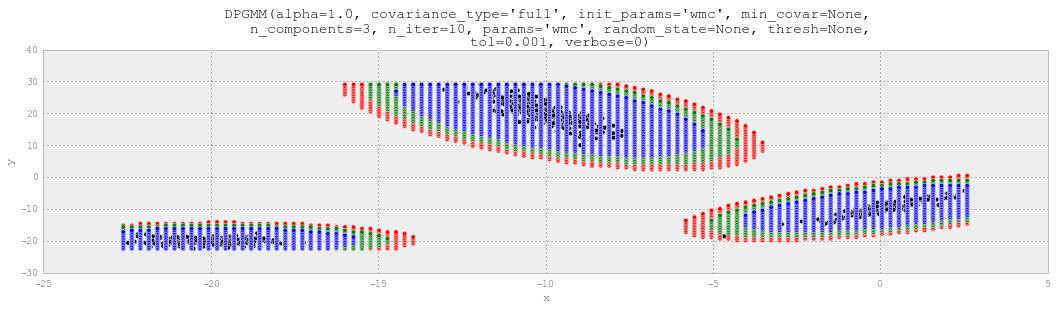

In [31]:
def plot_ranges(df,model,prob=[1e-4,1e-3,1e-2],colors=['r','g','b'], title=''):
    '''Scores the given set of points and plots the defined ranges in various colors'''
    ax = df.plot(kind='scatter', x='x', y='y',color='k')
    x=df['x']
    y=df['y']
    ax.set_title(title)
    n_samples=100
    xtest=[[x1,y1] for x1 in np.linspace(x.min(),x.max(),n_samples) for y1 in np.linspace(y.min(),y.max(),n_samples)]
    dfxtest=pd.DataFrame(xtest, columns=['x','y'])
    ypred=model.score(xtest)
    for i in np.arange(len(prob)):
        shown=dfxtest[exp(ypred)>=prob[i]]
        if len(shown)>0:
            shown.plot(kind='scatter', x='x', y='y', color=colors[i], ax=ax)

plot_ranges(dftest, model, title=model)

Interestingly enough this fit is not as tight as the one for a regular GMM (see part 2 for the corresponding graph) - yet the BIC was much better in this case.